## PROBLEM STATEMENT

The objective is to classify breast tumors as malignant or benign.

[The mammographic masses](http://archive.ics.uci.edu/ml/datasets/mammographic+mass) dataset contains 961 datapoints resulted from interpreting mammograms. The low positive predictive value of breast biopsy resulting from mammogram interpretation leads to approximately 70% unnecessary biopsies with benign outcomes. This data set can be used to predict the severity (benign or malignant) of a mammographic mass lesion. There are 516 benign and 445 malignant samples in this dataset.  

**DATA ATTRIBUTES**
1.  *BI-RADS* assessment: 1 to 5 (Basically an expert's opinion regarding the sample. 1 being definitely benign, 5 being highly mallignant)
2. *Age*: patient's age in years (integer) 
3. *Shape*: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal) 
4.* Margin*: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal) 
5. *Density*: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal) 
6. *Severity*: benign=0 or malignant=1 (binominal, goal field!)

** OBJECTIVE **

Based on the attributes above, can you identify a given sample as being mallignant or benign?

**SUMMARY**

1. [Exploratory Data Analysis (EDA)](#eda)
2. [Feature Selection](#feature_selection)
3. [Data Preprocessing](#preproc)
4. [Training & Test Data](#train_test)
5. [Metric of interest](#metric)
6. [A Handy function to plot the metrics](#hf)
7. [Machine Learning Begins](#ml)
    * [K-NN](#knn)
    * [Decision Trees](#dt)
    * [Random Forest Classifier](#rfc)
    * [Support Vector Machines (SVM)](#svm)
    * [Naive Bayes Classifier](#nb)
    * [Logistic Regression](#lr)
    * [Gradient Boosted Classifier](#gbc)

<a id='eda'></a>
**Exploratory Data Analysis**

EDA is the first step in any data analysis task. It gives you an intuitive feeling of what attributes might be important, how the data is distributed or whether we need to account for missing data.
Let's import some python libraries that we're gonna need.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn

plt.style.use('ggplot')

We want to store some metrics to later summarize our study at one place.
We'll define a dataframe for this purpose. It will basically be a table containing the mean precision,recall and accuracy for each algorithm we're gonna use.

In [2]:
d=[
   {'algo':'k-NN', 'precision':0, 'recall':0, 'accuracy':0}, 
   {'algo':'DT', 'precision':0, 'recall':0, 'accuracy':0},
   {'algo':'RFC', 'precision':0, 'recall':0, 'accuracy':0},
   {'algo':'SVM', 'precision':0, 'recall':0, 'accuracy':0},
   {'algo':'NB', 'precision':0, 'recall':0, 'accuracy':0},
   {'algo':'LR', 'precision':0, 'recall':0, 'accuracy':0},
   {'algo':'GBC', 'precision':0, 'recall':0, 'accuracy':0}
  ]

df_agg = pd.DataFrame(d)
# To get the order of columns I desire
df_agg = df_agg[['algo', 'accuracy', 'precision', 'recall']]

**Define the columns and load the dataset appropriately.**

If you take a peek into the dataset, you'll notice that there are some cells with ?. These values are missing and we need Pandas to treat them as such.

In [3]:
columns = ['BI-RADS','age','shape','margin','density','severity']
data = pd.read_csv('../input/mammographic_masses.data.txt', names=columns, na_values=['?'])

Let's take a quick look at out data. the info function of the Pandas will tell us if there are any missing values in the dataframe. Of the 961 rows in the given dataframe, only the severity column does not have missing values.

In [4]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 6 columns):
BI-RADS     959 non-null float64
age         956 non-null float64
shape       930 non-null float64
margin      913 non-null float64
density     885 non-null float64
severity    961 non-null int64
dtypes: float64(5), int64(1)
memory usage: 45.1 KB


,BI-RADS,age,shape,margin,density,severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1


Should we just neglect the missing data and drop the rows with missing values? This is often not a good idea. Doing so may result in loss of other useful information. Before we decide how to deal with the missing values, let's have a look at how our data is distributed.

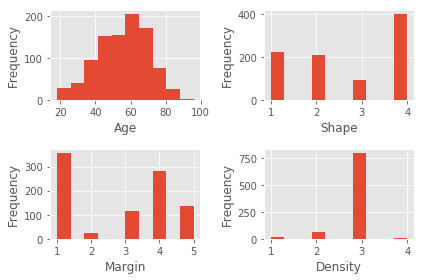

In [5]:
# We create a 2x2 grid of subplots
plt.subplot(2,2,1)
data['age'].plot('hist')
plt.xlabel('Age')

plt.subplot(2,2,2)
data['shape'].plot('hist')
plt.xlabel('Shape')

plt.subplot(2,2,3)
data['margin'].plot('hist')
plt.xlabel('Margin')

plt.subplot(2,2,4)
data['density'].plot('hist')
plt.xlabel('Density')

plt.tight_layout()

In [6]:
data[['age','shape','margin','density']].describe()

,age,shape,margin,density
count,956.000000,930.000000,913.000000,885.000000
mean,55.487448,2.721505,2.796276,2.910734
std,14.480131,1.242792,1.566546,0.380444
min,18.000000,1.000000,1.000000,1.000000
25%,45.000000,2.000000,1.000000,3.000000
50%,57.000000,3.000000,3.000000,3.000000
75%,66.000000,4.000000,4.000000,3.000000
max,96.000000,4.000000,5.000000,4.000000


There doesn't seem to be any abnormal behaviour in our data. To replace null values, let's select the **mean** for age, shape and margin rounded to the nearest integer and **mode** for density, since 3 seems to be the most common value for it. The choice of the characteristic used for imputation varies from problem to problem.

In [7]:
df = data.copy()

df['age'].fillna(int(data['age'].mean()), inplace=True)
df['shape'].fillna(int(data['shape'].mean()), inplace=True)
df['margin'].fillna(int(data['margin'].mean()), inplace = True)
df['density'].fillna(int(data['density'].mode()), inplace=True)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 6 columns):
BI-RADS     959 non-null float64
age         961 non-null float64
shape       961 non-null float64
margin      961 non-null float64
density     961 non-null float64
severity    961 non-null int64
dtypes: float64(5), int64(1)
memory usage: 45.1 KB


,BI-RADS,age,shape,margin,density,severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,3.0,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,3.0,1


Now, the missing values have been filled. so let's check if there is any class imbalance in our dataset. 

In [8]:
# there are two classes in our target value: benign and mallignant. There is a slight imbalance but nothing terrible.
np.bincount(df['severity'])

array([516, 445])

Remember that dataframe **data** is the original data with missing values, while **df** contains imputed values. Running the following command,  we can see that there's little difference between the mean and standard deviations original and new data. We can safely assume that our imputations did not significantly alter the data.

In [9]:
data[['age','shape','margin','density']].describe() - df[['age','shape','margin','density']].describe()

,age,shape,margin,density
count,-5.000000,-31.000000,-48.000000,-76.000000
mean,0.002536,0.023274,0.039772,-0.007060
std,0.037715,0.013595,0.029834,0.014575
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,0.000000,0.000000,0.000000,0.000000


**The Pairplot**

Let's see how our attributes vary with respect to each other. Plotting each variable against the other using the seaborn pairplot function yields the following figure. The diagonals of this figure represent a histogram for the corresponding variable. Red indicates malignant samples, while blue is for benign. At first glance, it doesn't seem very informative. But there are some important observations to be made in this figure. Notice:

* If age is less than mid twenties, the tumors detected are almost always benign (observe histogram age vs age)
* If the shape is irregular(value=4), there's a high chance that it might be malignant.
* If age > 35 and density =3, almost certainly it's going to be malignant

There may be more. The point being, always draw a pairplot to discover such trends in your data. It will help sanity check your model's results.

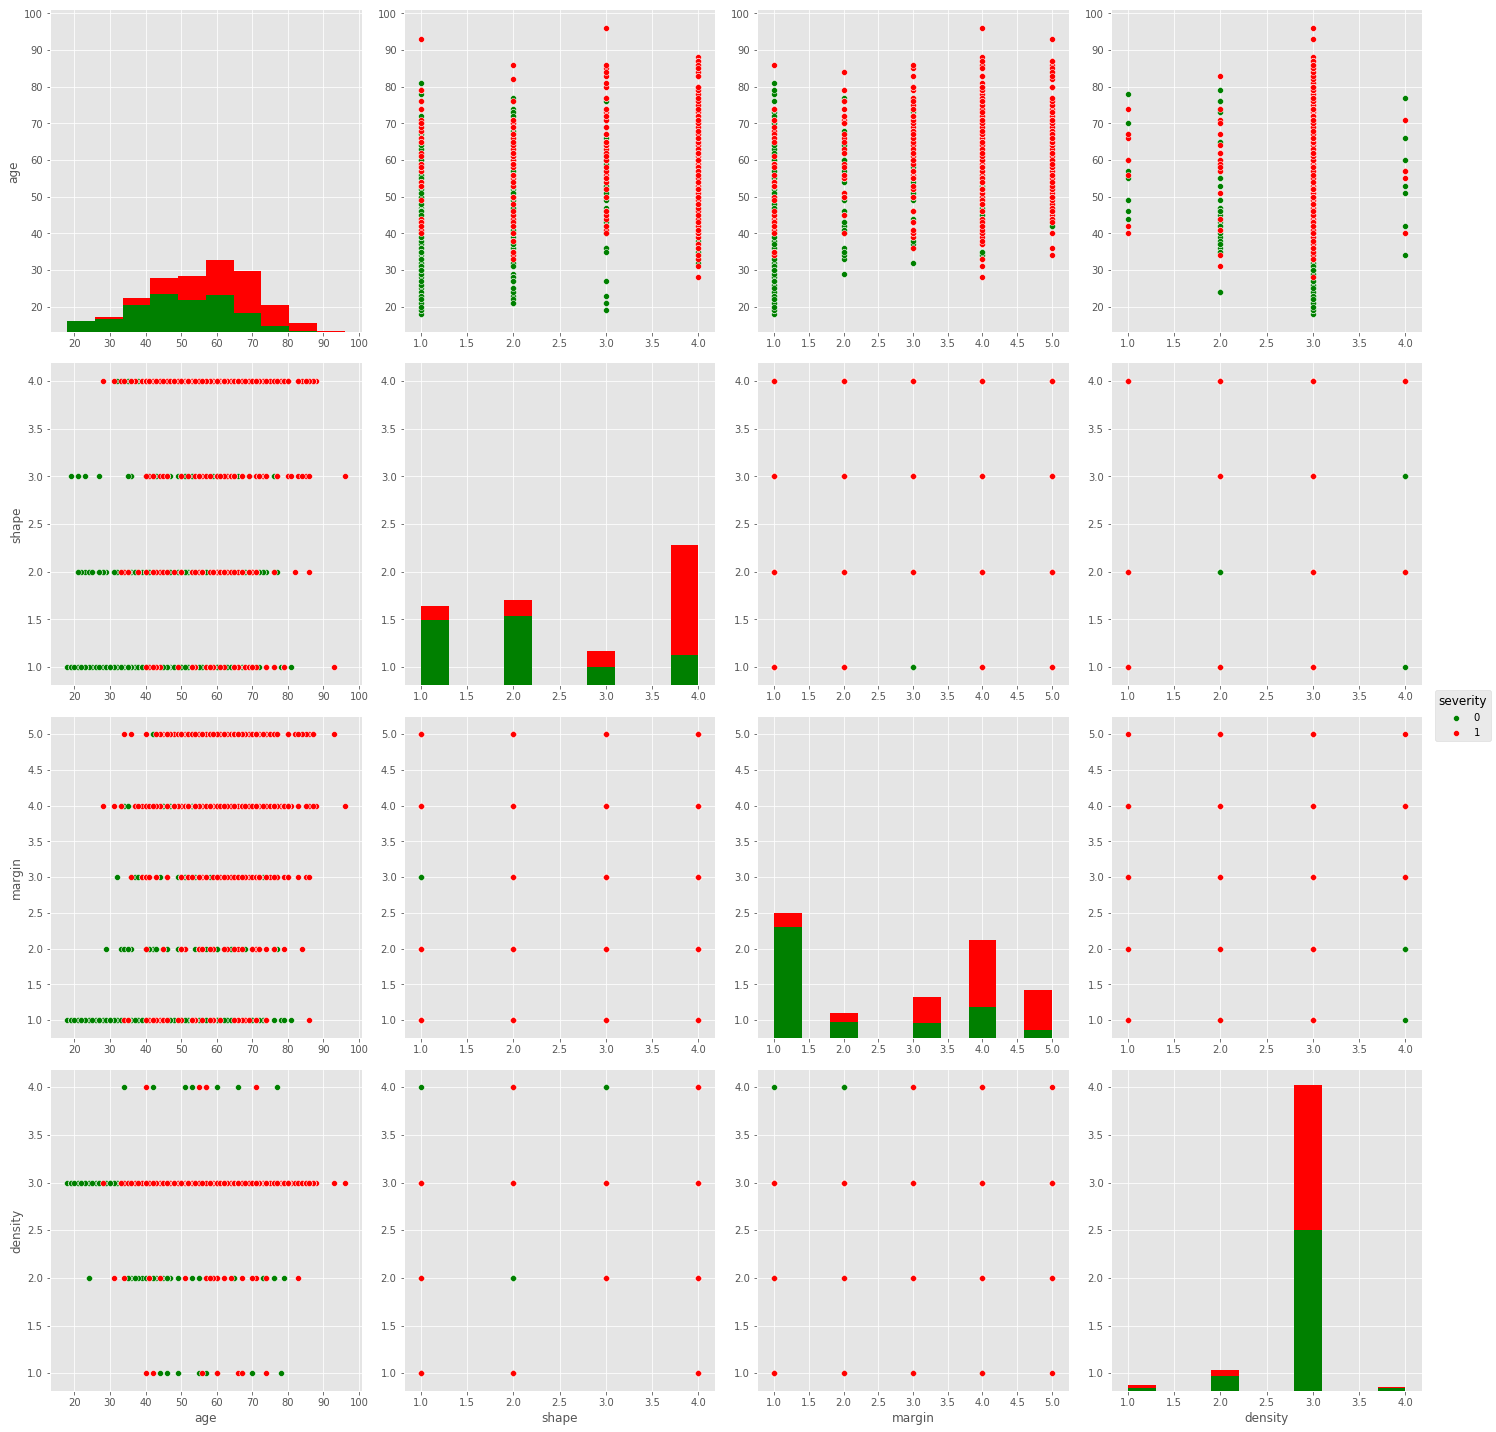

In [10]:
sbn.pairplot(data=df, vars=['age','shape','margin','density'],hue='severity', kind='scatter',size=5,palette={0:'g',1:'red'})

<a id='feature_selection'></a>
** Feature Selection**

Alright. The preprocessing is done. But there's one crucial step still remaining. What attributes should we select?
* The BI-RADS column is an assessment from experts which indicates if the tumor is malignant or benign as per their judgement
* Severity is clearly the target of our classification problem.

We need to drop these. The reason for dropping "BI-RADS" is that it will cause data leakage in our model, if included. Data leakage is a very common problem that prevents our model from being able to perform well. In brief, data leakage happens when a machine learning model gets access to data during the training phase that it should not have. Particularly, in our problem, including BI-RADS may encourage our models to learn:
> If an expert thinks that the tumor is malignant/benign then it is malignant/benign

which is a pretty useless conclusion, since we are trying to classify the tumors based on their physical characteristics. Including this attribute will cause excellent training phase accuracy and low test phase accuracy.

In [11]:
# convert data into numpy arrays required for scikit-learn
X = df[['age','shape','margin','density']].values
y = df['severity'].values

<a id='preproc' ></a>

** DATA PREPROCESSING **

In [12]:
from sklearn import preprocessing
scalar = preprocessing.StandardScaler()
X_scaled = scalar.fit_transform(X)
X_scaled

array([[ 0.79772558,  0.24562886,  1.46069388,  0.22480407],
       [-0.86491158, -1.38229756, -1.14362304,  0.22480407],
       [ 0.17423665,  1.05959206,  1.46069388,  0.22480407],
       ..., 
       [ 0.58989594,  1.05959206,  1.46069388,  0.22480407],
       [ 0.72844903,  1.05959206,  1.46069388,  0.22480407],
       [ 0.45134284,  0.24562886,  0.15853542,  0.22480407]])

<a id='train_test'></a>
** SEPARATING TRAINING AND TEST DATA **

Missing values have been handled and Input features have been standardized. Now it is time to split our data into Training and Test sets.

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10,shuffle=True)
# The shape of training and test partitions
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(768, 4) (193, 4)
(768,) (193,)


<a id='metric' > </a>
** MEASURING PERFORMANCE **

What metric should we try to optimize in our model? The first answer that pops into mind is Accuracy. While it often serves, there are many cases where it is insufficient. For example, assume you're building a classifier to identify terrorists who board international flights every year. You create a dummy model that classifies every passenger as a non-terrorist. Since most of the passengers are non-terrorists, the accuracy of this model would be around 99.99%. But it completely fails in achieving what we wanted, which is to be able to identify terrorists.

In our case, we're interested in maximizing a metric called **Recall**. It is defined as True Positives/(True Positives + False Negetives)

To maximize recall, we'd have to minimize false negatives. Meaning: we want to minimize those cases where a subject's tumor is malignant, but it is classified as benign. If a patient with a malignant tumor goes untreated, there would be horrible consequences down the line. 

Precision is defined as True Positives/ (True Positives/False Positives). So intuitively, precision is "Fraction of the selected samples which are relevant" while recall is "Fraction of the relevant samples which were selected". Let's import recall, precision and accuracy metrics.

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

<a id='hf' ></a>
** A HANDY FUNCTION **

Let's define a handy function to plot all three metrics against a particular hyperparameter of the algorithm.

In [15]:
def plot_accuracy_precision_recall(accuracy, precision, recall,hyper_parameter_name, algo, text_position):
    
    best_r = 0
    
    for k, r in recall.items():
        if r > best_r:
            best_r = r
            best_k=k
    
    plt.figure(figsize=(8,5))
    
    plt.plot(accuracy.keys(), accuracy.values(), label='Accuracy')
    plt.plot(precision.keys(), precision.values(), label='Precision', color='green')
    plt.plot(recall.keys(), recall.values(), label='Recall', color='blue')
    plt.annotate('Best '+hyper_parameter_name+' ( '+str(best_k)+','+"{0:.2f}".format(best_r)+' )\n Accuracy: '+'{0:.2f}'.format(accuracy[best_k]), xy=(best_k,best_r), xytext=text_position, arrowprops={'color':'black', 'width':0.2, 'headwidth':4.0})
    plt.legend()
    plt.xlabel(hyper_parameter_name)
    plt.ylabel('Metric')
    plt.title(algo)

<a id='knn' ></a>
**K-Nearest Neighbors**

In [16]:
from sklearn.neighbors import KNeighborsClassifier

accuracy={}
precision={}
recall={}

for k in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_predicted = knn.predict(X_test)
    accuracy[k]=accuracy_score(y_test, y_predicted)
    precision[k]=precision_score(y_test, y_predicted)
    recall[k]=recall_score(y_test, y_predicted)
    
    #scores = [np.mean(accuracy.values()), np.mean(precision.values()), np.mean(recall.values())]


df_agg.loc[df_agg.algo == 'k-NN', 'accuracy'] = np.mean(list(accuracy.values()))
df_agg.loc[df_agg.algo == 'k-NN', 'precision'] = np.mean(list(precision.values()))
df_agg.loc[df_agg.algo == 'k-NN', 'recall'] = np.mean(list(recall.values()))

#print(df_agg)
#plot_accuracy_precision_recall(accuracy, precision, recall, hyper_parameter_name='K', algo='KNN', text_position=(8.0,0.6))

Looking at the graph above, we can see that for the range of K that we selected, maximum recall of 0.75 is obtained for K=9. The accuracy there is 0.78, which isn't terribly poor. Is it the best possible pair of values? No! There could be a better pair beyond our range. But you get the idea. If you are dead set on finding the absolute best value, we can perform a GridSearch to tune the hyperparameter K.

<a id='dt' > </a>
** Decision Trees **

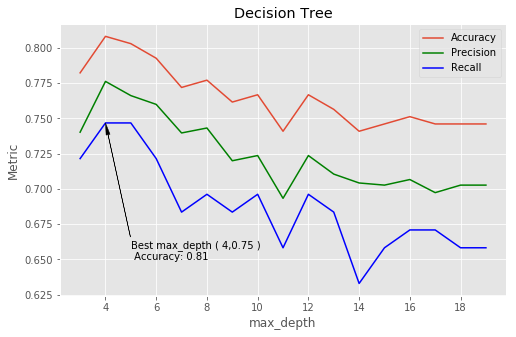

In [17]:
from sklearn.tree import DecisionTreeClassifier

accuracy={}
precision={}
recall={}

for k in range(3,20):
    dtc = DecisionTreeClassifier(random_state=1, max_depth=k)
    dtc.fit(X_train, y_train)
    y_predicted = dtc.predict(X_test)
    accuracy[k]=accuracy_score(y_test, y_predicted)
    precision[k]=precision_score(y_test, y_predicted)
    recall[k]=recall_score(y_test, y_predicted)
    

plot_accuracy_precision_recall(accuracy, precision, recall, hyper_parameter_name='max_depth', algo='Decision Tree', text_position=(5,0.65))

df_agg.loc[df_agg.algo == 'DT', 'accuracy'] = np.mean(list(accuracy.values()))
df_agg.loc[df_agg.algo == 'DT', 'precision'] = np.mean(list(precision.values()))
df_agg.loc[df_agg.algo == 'DT', 'recall'] = np.mean(list(recall.values()))

#print(df_agg)

<a id='rfc' > </a>
**Random Forest Classifier**

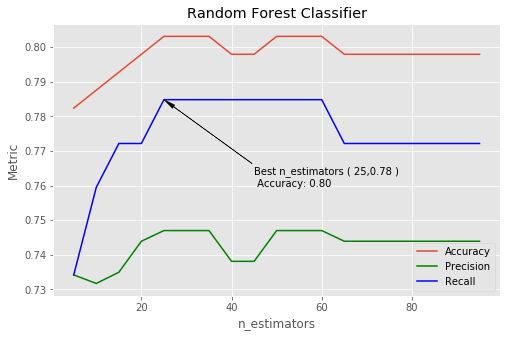

In [18]:
from sklearn.ensemble import RandomForestClassifier

accuracy={}
precision={}
recall={}


for n in range(5,100,5):

    rfc = RandomForestClassifier(n_estimators=n, random_state=1, max_depth=5)
    rfc.fit(X_train,y_train)
    y_predicted = rfc.predict(X_test)
    accuracy[n] = accuracy_score(y_test, y_predicted)
    precision[n] = precision_score(y_test, y_predicted)
    recall[n] = recall_score(y_test, y_predicted)
    
plot_accuracy_precision_recall(accuracy, precision, recall, hyper_parameter_name='n_estimators', algo='Random Forest Classifier', text_position=(45,0.76))

df_agg.loc[df_agg.algo == 'RFC', 'accuracy'] = np.mean(list(accuracy.values()))
df_agg.loc[df_agg.algo == 'RFC', 'precision'] = np.mean(list(precision.values()))
df_agg.loc[df_agg.algo == 'RFC', 'recall'] = np.mean(list(recall.values()))

#print(df_agg)

<a id='svm' > </a>
** Support Vector Machine **

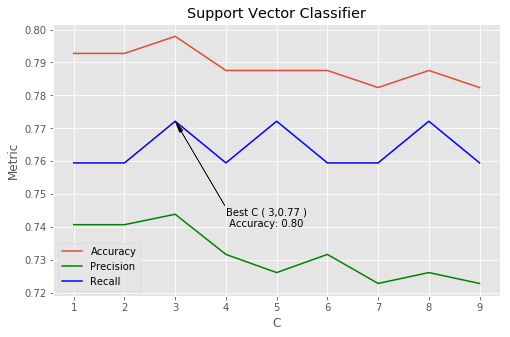

In [19]:
from sklearn import svm

accuracy={}
precision={}
recall={}


for c in range(1,10):
    svc = svm.SVC(kernel='rbf', C=c,gamma='auto')
    svc.fit(X_train, y_train)
    y_predicted = svc.predict(X_test)
    accuracy[c] = accuracy_score(y_test, y_predicted)
    precision[c] = precision_score(y_test, y_predicted)
    recall[c] = recall_score(y_test, y_predicted)

    
plot_accuracy_precision_recall(accuracy, precision, recall, hyper_parameter_name='C', algo='Support Vector Classifier', text_position=(4,0.74))

df_agg.loc[df_agg.algo == 'SVM', 'accuracy'] = np.mean(list(accuracy.values()))
df_agg.loc[df_agg.algo == 'SVM', 'precision'] = np.mean(list(precision.values()))
df_agg.loc[df_agg.algo == 'SVM', 'recall'] = np.mean(list(recall.values()))

#print(df_agg)

<a id='nb' > </a>
**Naive Bayes Classifier**

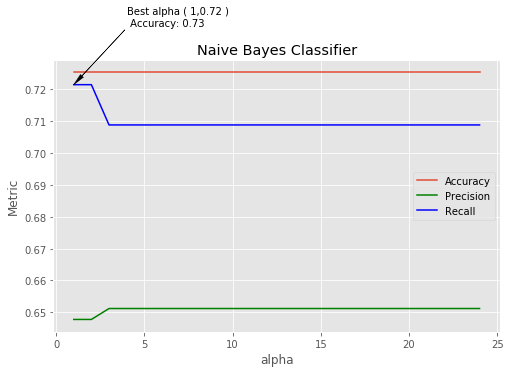

In [20]:
from sklearn.naive_bayes import MultinomialNB
accuracy={}
precision={}
recall={}

for alpha in range(1,25):
    nbc = MultinomialNB(alpha=alpha)
    nbc.fit(X_train, y_train)
    y_predicted = nbc.predict(X_test)
    accuracy[alpha] = accuracy_score(y_test, y_predicted)
    precision[alpha] = precision_score(y_test, y_predicted)
    recall[alpha] = recall_score(y_test, y_predicted)
    
plot_accuracy_precision_recall(accuracy, precision, recall, hyper_parameter_name='alpha', algo='Naive Bayes Classifier', text_position=(4,0.74))

df_agg.loc[df_agg.algo == 'NB', 'accuracy'] = np.mean(list(accuracy.values()))
df_agg.loc[df_agg.algo == 'NB', 'precision'] = np.mean(list(precision.values()))
df_agg.loc[df_agg.algo == 'NB', 'recall'] = np.mean(list(recall.values()))

#print(df_agg)

<a id = 'lr' > </a>
### Logistic Regression

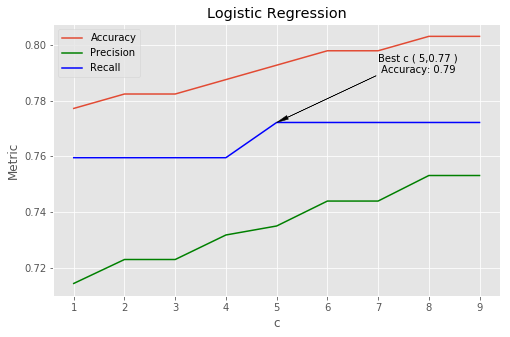

In [ ]:
from sklearn.linear_model import LogisticRegression

accuracy={}
precision={}
recall={}

for c in range(1,10):
    lr = LogisticRegression(penalty='l2', C=c)
    lr.fit(X_train, y_train)
    y_predicted = lr.predict(X_test)
    accuracy[c] = accuracy_score(y_test, y_predicted)
    precision[c] = precision_score(y_test, y_predicted)
    recall[c] = recall_score(y_test, y_predicted)
    
plot_accuracy_precision_recall(accuracy, precision, recall, hyper_parameter_name='c', algo='Logistic Regression', text_position=(7,0.79))

df_agg.loc[df_agg.algo == 'LR', 'accuracy'] = np.mean(list(accuracy.values()))
df_agg.loc[df_agg.algo == 'LR', 'precision'] = np.mean(list(precision.values()))
df_agg.loc[df_agg.algo == 'LR', 'recall'] = np.mean(list(recall.values()))

#print(df_agg)

<a id = 'gbc' > </a>
### Gradient Boosted Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

accuracy={}
precision={}
recall={}

for c in list(np.arange(100,1000,25)):
    gbc = GradientBoostingClassifier( n_estimators=c, max_depth=10)
    gbc.fit(X_train, y_train)
    y_predicted = gbc.predict(X_test)
    accuracy[c] = accuracy_score(y_test, y_predicted)
    precision[c] = precision_score(y_test, y_predicted)
    recall[c] = recall_score(y_test, y_predicted)
    
plot_accuracy_precision_recall(accuracy, precision, recall, hyper_parameter_name='n_estimators', algo='Gradient Boosted Classifier', text_position=(1100,0.73))

df_agg.loc[df_agg.algo == 'GBC', 'accuracy'] = np.mean(list(accuracy.values()))
df_agg.loc[df_agg.algo == 'GBC', 'precision'] = np.mean(list(precision.values()))
df_agg.loc[df_agg.algo == 'GBC', 'recall'] = np.mean(list(recall.values()))

#print(df_agg)

**SUMMARY**

We tried 7 supervised classification algorithms in this study. It's time to summarize the results. We'll plot a combined bar plot, each set of bars indicating precision, recall and accuracy for an algorithm.
We need to slightly alter the dataframe df_agg to being it into a form that seaborn's factoplot function can easily work with. Do do that, let's melt the dataframe to combine columns accuracy, precision and recall.


In [ ]:
df_melted = pd.melt(df_agg,id_vars=['algo'], value_vars=['accuracy','precision','recall'],var_name='metric',value_name='value')
#print(df_melted)
g=sbn.factorplot(x='algo', y='value', hue='metric', data=df_melted,kind='bar',size=4, palette={'accuracy':'y', 'precision':'g','recall':'r'})
#g.set_xticklabels(rotation=70)
plt.xlabel('Algorithm')
plt.title('Summary of our study')

## Conclusion


In this notebook, we saw how easy scikit-learn makes it to use commonly known supervised machine learning algorithms. The paradigm is simple. You import the required algorithm class from sklearn, create an object of it by passing it the necessary hyperparameters, fit it to training data and finally predict/test on the test data.

Is this the best possible result we could have achieved on this dataset? No! Note that we've barely scratched the surface of these algorithms. Almost each of them can be finetuned to improve their performance. That involves careful selection of hyperparameters (e.g. 'C' for Support Vector Machines or 'max_depth' for Decision Trees). Generally to find out the best parameters, GridSearchCV is used, which does an exhaustive search on all the combinations of parameters that you provide. One more common practice that we didn't cover in this notebook is -- K-fold Cross Validation. Which is just a way of avoiding selection bias. It splits the data into k sets, each of which is used as the test set against the rest of the data, in one iteration.

To conclude, we can classify the tumors with about 80% confidence if we use Random Forest Classifier.